# AIS Data Processing

## Data Processing Method
- break AIS data up into discrete ship sample events
- uniformly resample each ship pass (using linear interpolation)

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import datetime
import plotly.express as px
import plotly
import plotly.graph_objects as go
import pickle
import AIS_tools
import scipy
import pickle
import math as m
import geopy

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Get raw AIS data
df = AIS_tools.get_AIS_data(load_pickle=True)

In [3]:
# Break data into list of ship passes
ship_passes, pass_start_idxs = AIS_tools.single_ship_pass(df, load_pickle=True)

In [16]:
# Uniformly resample in time
all_ships = AIS_tools.resample_time_all(df_ls=ship_passes, load_pickle=False)[0]

0.04092710974608056544

/Users/jhrag/opt/anaconda3/envs/ooi_dev/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jhrag/opt/anaconda3/envs/ooi_dev/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/Users/jhrag/opt/anaconda3/envs/ooi_dev/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


KeyError: 0

## Looking at Histogram Distributions

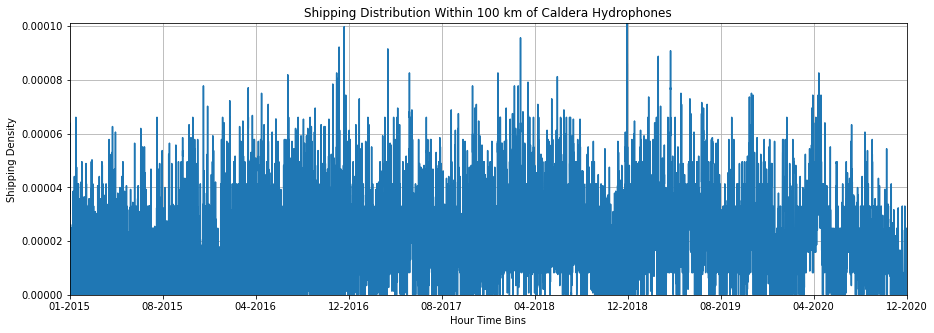

In [6]:
hist_time, time_bins = np.histogram(all_ships['time_val']*1e-9/3600, bins=(365*24*6+2), density=True)
bin_width = time_bins[1] - time_bins[0]

# Get Date Ticks
time_bins_str = pd.to_datetime(time_bins*1e+9*3600).strftime('%m-%Y').to_numpy()
xticks = np.linspace(0,len(hist_time), 10).astype(int)
xlabels = time_bins_str[xticks]

# Create Figure
fig = plt.figure(figsize=(15,5))
plt.plot(hist_time)
plt.xticks(xticks, xlabels)
plt.grid()
plt.ylabel('Shipping Density')
plt.xlabel('Hour Time Bins')
plt.xlim([0, len(hist_time)])
plt.ylim([0, np.max(hist_time)])
plt.title('Shipping Distribution Within 100 km of Caldera Hydrophones')

#fig.savefig('Shipping_Distribution_in_time_per_hour.png',dpi=200)

Text(0.5, 1.0, 'Percent of Shipping Mass for 201 Hour Segments')

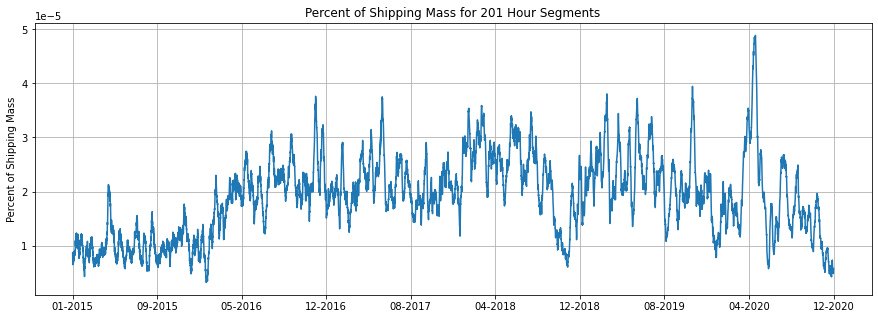

In [7]:
# Getting 200 hour moving average
bin_width = time_bins[1] - time_bins[0]
kernel = np.ones(201)
hist_ma201 = np.convolve(hist_time, kernel, mode='valid')*bin_width

# Get Date Ticks
time_bins_str = pd.to_datetime(time_bins[100:-100]*1e+9*3600).strftime('%m-%Y').to_numpy()
xticks = np.linspace(0,len(time_bins_str)-1, 10).astype(int)
xlabels = time_bins_str[xticks]

fig = plt.figure(figsize=(15,5))
plt.plot(hist_ma201/np.sum(hist_ma201))
plt.ylabel('Percent of Shipping Mass')
plt.xticks(xticks, xlabels)
plt.grid()
plt.title('Percent of Shipping Mass for 201 Hour Segments')

#fig.savefig('201_hour_shipping_percentage.png',dpi=200)

(1000, 360)


Text(0.5, 1.0, 'Bearing / Time Shipping Distribution')

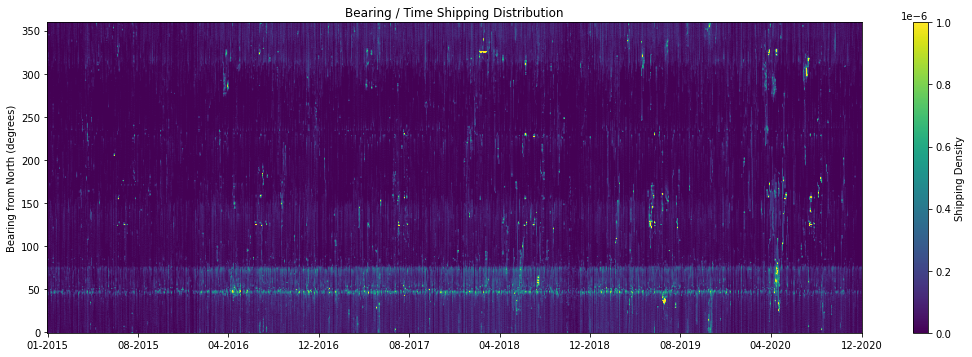

In [6]:
H, xbins, ybins = np.histogram2d(all_ships['time_val']*1e-9/3600, all_ships['bearing'], bins=[1000,360], density=True)
ybins.shape
print(H.shape)
# Get Date Ticks
time_bins_str = pd.to_datetime(xbins*1e+9*3600).strftime('%m-%Y').to_numpy()
xticks = np.linspace(0,len(time_bins_str)-1, 10).astype(int)
xlabels = time_bins_str[xticks]


fig = plt.figure(figsize=(15,5))
plt.imshow(H.T, aspect='auto', origin='lower', vmax=1e-6)

plt.ylabel('Bearing from North (degrees)')
cbar = plt.colorbar()
cbar.set_label('Shipping Density')
plt.xticks(xticks, xlabels)
plt.tight_layout()
plt.title('Bearing / Time Shipping Distribution')

#fig.savefig('bearing_time_shipping_distribution.png',dpi=200)

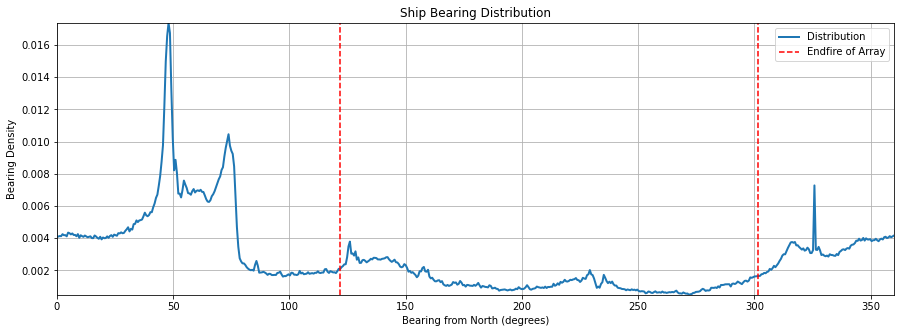

In [9]:
hist_bearing, bearing_bins = np.histogram(all_ships['bearing'], bins=600, density=True)

y_min=np.min(hist_bearing)
y_max=np.max(hist_bearing)
endfire = [121.6%360, (121.6+180)%360]

fig = plt.figure(figsize=(15,5))

plt.plot(bearing_bins[1:], hist_bearing, linewidth=2, label='Distribution')
plt.plot([endfire[0], endfire[0]],[y_min, y_max],'r--', label='')
plt.plot([endfire[1], endfire[1]],[y_min, y_max],'r--', label='Endfire of Array')

plt.xlabel('Bearing from North (degrees)')
plt.ylabel('Bearing Density')
plt.title('Ship Bearing Distribution')
plt.grid()
plt.xlim([0, 360])
plt.ylim([y_min, y_max])

plt.legend()
#fig.savefig('bearing_distribution.png',dpi=200)


# Looking at Lat Lon Distribution

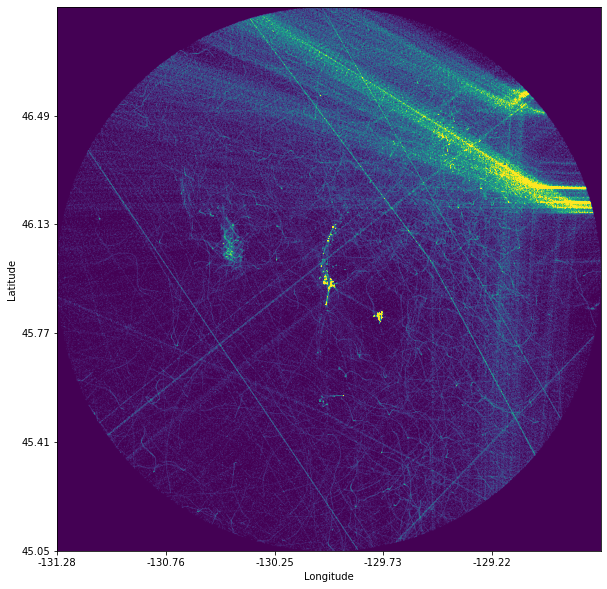

In [8]:
from matplotlib.ticker import FormatStrFormatter
radius100 = all_ships[all_ships['ranges (km)'] < 100]

heatmap, xedges, yedges = np.histogram2d(radius100.lons, radius100.lats, bins=1000)



xticks = np.array([0, 200, 400, 600, 800])
yticks = np.array([0, 200, 400, 600, 800])
xlabels = np.char.mod('%.2f',xedges[xticks])
ylabels = np.char.mod('%.2f',yedges[yticks])

fig = plt.figure(figsize=(10,10))
plt.imshow(heatmap.T, vmax = 10, origin='lower')
#plt.colorbar()
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig.savefig('density_heatmap_resampled.png',dpi=200)


# Looking at Histogram of Speed

(0.0, 5.0)

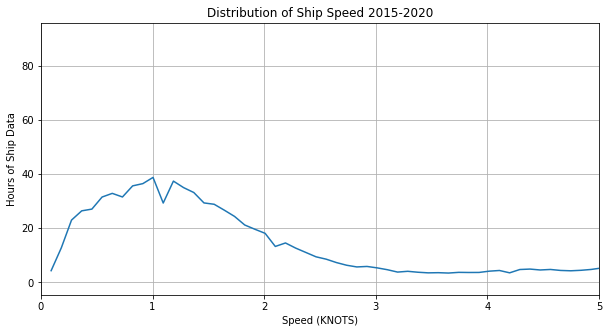

In [9]:
speed = all_ships['SPEED (KNOTSx10)'].to_numpy()
speed_H, bins = np.histogram(speed, bins=1000)

speed_H = speed_H/5/60
bins = bins/10

fig = plt.figure(figsize=(10,5))
plt.plot(bins[1:], speed_H)
plt.grid()
plt.xlabel('Speed (KNOTS)')
plt.ylabel('Hours of Ship Data')
plt.title('Distribution of Ship Speed 2015-2020')
plt.xlim([0, 5])

#fig.savefig('distribution_of_ship_speed.eps', format='eps')

In [5]:
slow_ships = all_ships[all_ships['SPEED (KNOTSx10)']<3]

H, time_bins, bearing_bins = np.histogram2d(slow_ships['time_val']*1e-9/3600, slow_ships['bearing'], bins=[1000,360], density=True)
H = H*len(slow_ships)/12

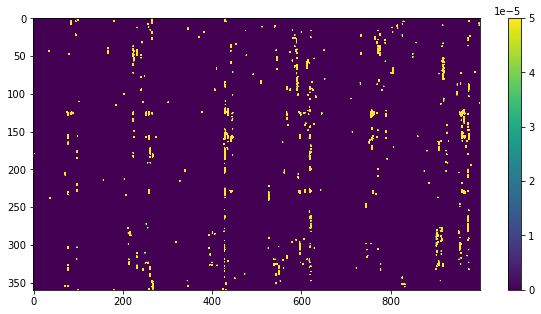

In [8]:
fig = plt.figure(figsize=(10,5))
plt.imshow(H.T, vmax=0.00005, aspect='auto')
plt.colorbar()

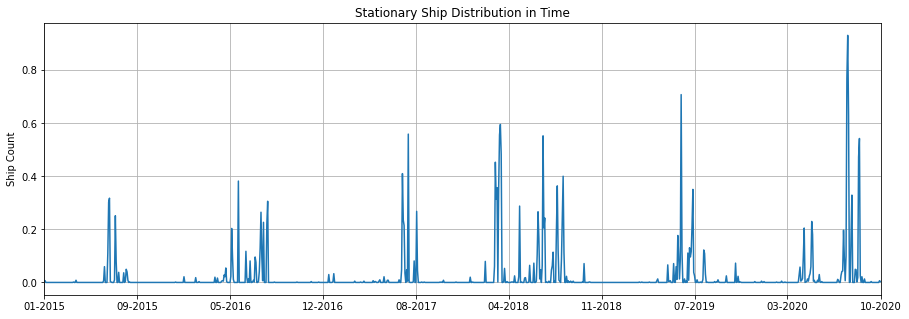

In [45]:
# Get Date Ticks
time_bins_str = pd.to_datetime(time_bins*1e+9*3600).strftime('%m-%Y').to_numpy()
xticks = np.linspace(0,H.shape[0], 10).astype(int)
xlabels = time_bins_str[xticks]

fig = plt.figure(figsize=(15,5))
plt.plot(np.sum(H,axis=1))
plt.xticks(xticks, xlabels)
plt.grid()
plt.xlim([0,1000])
plt.ylabel('Ship Count')
plt.title('Stationary Ship Distribution in Time')

fig.savefig('stationary_ship_dist_in_time.png',dpi=200)

### Look at slow ship types

In [14]:
slow_ships

,level_0,index,MMSI,SHIPNAME,VESSEL TYPE,STATUS,SPEED (KNOTSx10),LAT,LON,COURSE,HEADING,TIMESTAMP UTC,LENGTH,time,time_val,Range (km)
0,861280,217475,369272000,POLAR DISCOVERY,Crude Oil Tanker,0,123,45.74532,-129.1104,141,150,2018-11-15 07:20:41,272.69,2018-11-15 07:20:41,1542266441000000000,72.014606
